In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from datetime import datetime as dt


In [118]:
years = [i for i in range(2001, 2008)]
location = 'A801'

filenames = []
for year in years:
    filenames.extend([f'{year}/{file.name}' for file in os.scandir(f'inmet-data/{year}') if location in file.name])
dfs = [pd.read_csv(f"inmet-data/{f}", delimiter=';', header=8,encoding="iso-8859-1") for f in filenames]

raw_data = pd.concat(dfs).reset_index()
raw_data

,index,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2001-01-01,00:00,0,1009,1009,"1008,5",-9999,21,"15,8",...,"20,9","16,1","15,6",72,69,72,90,"5,8","2,1",NaN
1,1,2001-01-01,01:00,0,"1009,4","1009,4",1009,-9999,"20,5","15,6",...,"20,5","15,8","15,5",73,71,73,109,"5,3","2,7",NaN
2,2,2001-01-01,02:00,0,"1009,1","1009,3","1009,1",-9999,20,"15,5",...,20,"15,6","15,5",75,73,75,96,"4,2","1,8",NaN
3,3,2001-01-01,03:00,0,"1008,8","1009,1","1008,8",-9999,"19,9","15,5",...,"19,8","15,6","15,5",76,75,76,110,"4,3","1,6",NaN
4,4,2001-01-01,04:00,0,"1008,7","1008,9","1008,7",-9999,"19,4","15,6",...,"19,4","15,6","15,5",78,76,78,136,"4,2","2,2",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61339,8755,2007-12-31,19:00,0,"1004,9","1005,6","1004,9","2765,1","31,4","17,9",...,"30,9","20,9","17,9",54,45,45,152,6,"2,1",NaN
61340,8756,2007-12-31,20:00,0,"1004,7",1005,"1004,7","2012,7","31,3","18,5",...,"30,5",19,"16,2",48,40,47,153,"7,1","2,5",NaN
61341,8757,2007-12-31,21:00,0,"1004,7","1004,7","1004,5","1307,6","30,1","18,3",...,"30,1","19,1","17,6",52,44,49,141,"6,4","2,1",NaN
61342,8758,2007-12-31,22:00,0,"1005,2","1005,2","1004,7","329,1","27,7","19,7",...,"27,7","19,9","18,4",62,49,62,134,"6,2","2,8",NaN


0       2001-01-01 00:00:00
1       2001-01-01 01:00:00
2       2001-01-01 02:00:00
3       2001-01-01 03:00:00
4       2001-01-01 04:00:00
                ...        
61339   2007-12-31 19:00:00
61340   2007-12-31 20:00:00
61341   2007-12-31 21:00:00
61342   2007-12-31 22:00:00
61343   2007-12-31 23:00:00
Length: 61344, dtype: datetime64[ns]

In [136]:
cols = raw_data.columns
raw_data['datetime'] = pd.to_datetime(raw_data[cols[1]] + ' ' + raw_data[cols[2]], format='%Y-%m-%d %H:%M')


def parseToFloat(col):
    return raw_data[col].apply(lambda x : float(x.replace(',', '.')) if(isinstance(x, str)) else x)


# global-radiation
raw_data['global-radiation'] = parseToFloat("RADIACAO GLOBAL (KJ/m²)")

# precipitation
raw_data['total-precipitation'] = parseToFloat("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)")

# temperature
raw_data['temperature-last-hour-max'] = parseToFloat("TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)")
raw_data['temperature-last-hour-min'] = parseToFloat("TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)")

# wind
raw_data['wind-speed'] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")

# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.loc[:, ~raw_data.columns.str.contains("^Unnamed")].drop(
    columns=[
        'index',
        "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
        "PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)",
        "PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)",
        "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
        "TEMPERATURA DO PONTO DE ORVALHO (°C)",
        "TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)",
        "TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)",
        "UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)",
        "UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)",
        "DATA (YYYY-MM-DD)",
        "HORA (UTC)",
    ]
).rename(
    columns={
        "UMIDADE RELATIVA DO AR, HORARIA (%)": "relative-humidity",
        "VENTO, DIREÇÃO HORARIA (gr) (° (gr))": "wind-direction",
        "VENTO, RAJADA MAXIMA (m/s)": "wind-speed-max-gust",
    }
)

renamed_data.datetime

0       2001-01-01 00:00:00
1       2001-01-01 01:00:00
2       2001-01-01 02:00:00
3       2001-01-01 03:00:00
4       2001-01-01 04:00:00
                ...        
61339   2007-12-31 19:00:00
61340   2007-12-31 20:00:00
61341   2007-12-31 21:00:00
61342   2007-12-31 22:00:00
61343   2007-12-31 23:00:00
Name: datetime, Length: 61344, dtype: datetime64[ns]

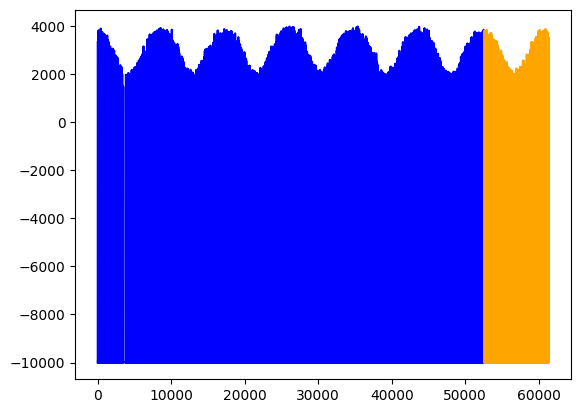

In [141]:
train = renamed_data['global-radiation'][renamed_data.datetime < pd.to_datetime('2007', format='%Y')]
test = renamed_data['global-radiation'][renamed_data.datetime >= pd.to_datetime('2007', format='%Y')]

plt.plot(train, color='blue')
plt.plot(test, color='orange')

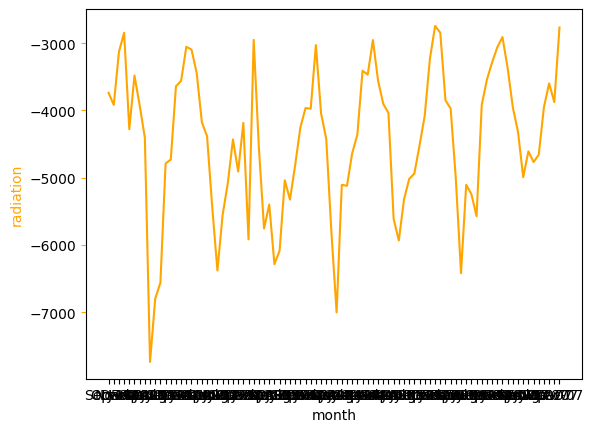

In [31]:
by_month = renamed_data
by_month['month'] =  by_month['date'].apply(lambda d: dt.strftime(dt.strptime(d, '%Y/%m/%d'), '%b-%y'))
monthly_radiation = by_month.groupby('month')['global-radiation'].transform('mean')
monthly_precipitation = by_month.groupby('month')['total-precipitation'].transform('mean')
monthly_wind = by_month.groupby('month')['wind-speed'].transform('mean')
months = by_month['month']

fig, ax1 = plt.subplots()



ax1.set_xlabel('month')
ax1.tick_params()
ax1.set_ylabel('radiation', color='orange')
ax1.plot(months, monthly_radiation, color='orange')
ax1.tick_params(axis='y', color='orange')

# ax2= ax1.twinx()
# ax2.set_ylabel('precipitation')
# ax2.plot(months, monthly_precipitation)
# ax2.tick_params(axis='y')

# ax3 = ax1.twinx()
# ax3.set_ylabel('wind', color='green')
# ax3.plot(months, monthly_wind, color='green')
# ax3.tick_params(axis='y', color='green')

plt.show()
